### Load Preprocessed data 

In [13]:
# retrieve the preprocessed data from previous notebook

%store -r x_train 
%store -r x_test 
%store -r y_train 
%store -r y_test 
%store -r yy 
%store -r le

#### Feature Extraction refinement 

In the prevous feature extraction stage, the MFCC vectors would vary in size for the different audio files (depending on the samples duration). 

However, CNNs require a fixed size for all inputs. To overcome this we will zero pad the output vectors to make them all the same size. 

In [23]:
# import numpy as np
# max_pad_len = 174

# def extract_features(file_name):
   
#     try:
#         audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
#         mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
#         pad_width = max_pad_len - mfccs.shape[1]
#         mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
#     except Exception as e:
#         print("Error encountered while parsing file: ", file_name)
#         return None 
     
#     return mfccs

In [2]:
def extract_feature(file_name):
   
    try:
        audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None, None

    return np.array([mfccsscaled])

In [4]:
# Load various imports 
import pandas as pd
import os
import librosa

# Set the path to the full UrbanSound dataset 
fulldatasetpath = '../UrbanSound8K/audio/'

metadata = pd.read_csv('../UrbanSound8K/metadata/UrbanSound8K.csv')

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["class"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files') 

C:\Users\Ak875\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\Ak875\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
C:\Users\Ak875\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
C:\Users\Ak875\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)


Finished feature extraction from  8732  files


In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

###  Convolutional Neural Network (CNN) model architecture 


In [6]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

### Compiling the model 

For compiling our model, we will use the same three parameters as the previous model: 

In [7]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [8]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 173, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 86, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 86, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 42, 32)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 9, 42, 32)         0

### Training 

Here we will train the model. As training a CNN can take a sigificant amount of time, we will start with a low number of epochs and a low batch size. If we can see from the output that the model is converging, we will increase both numbers.  

In [9]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

#num_epochs = 12
#num_batch_size = 128

num_epochs = 101
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/101
28/28 [==============================] - ETA: 0s - loss: 4.6246 - accuracy: 0.1668
Epoch 1: val_loss improved from inf to 2.24058, saving model to saved_models\weights.best.basic_cnn.hdf5
28/28 [==============================] - 10s 273ms/step - loss: 4.6246 - accuracy: 0.1668 - val_loss: 2.2406 - val_accuracy: 0.1580
Epoch 2/101
28/28 [==============================] - ETA: 0s - loss: 2.0192 - accuracy: 0.2856
Epoch 2: val_loss improved from 2.24058 to 2.00326, saving model to saved_models\weights.best.basic_cnn.hdf5
28/28 [==============================] - 6s 211ms/step - loss: 2.0192 - accuracy: 0.2856 - val_loss: 2.0033 - val_accuracy: 0.3005
Epoch 3/101
28/28 [==============================] - ETA: 0s - loss: 1.7392 - accuracy: 0.3812
Epoch 3: val_loss improved from 2.00326 to 1.77977, saving model to saved_models\weights.best.basic_cnn.hdf5
28/28 [==============================] - 6s 215ms/step - loss: 1.7392 - accuracy: 0.3812 - val_loss: 1.7798 - val_accuracy: 0.403

Epoch 26/101
28/28 [==============================] - ETA: 0s - loss: 0.6684 - accuracy: 0.7784
Epoch 26: val_loss improved from 0.75448 to 0.70899, saving model to saved_models\weights.best.basic_cnn.hdf5
28/28 [==============================] - 7s 266ms/step - loss: 0.6684 - accuracy: 0.7784 - val_loss: 0.7090 - val_accuracy: 0.7773
Epoch 27/101
28/28 [==============================] - ETA: 0s - loss: 0.6339 - accuracy: 0.7824
Epoch 27: val_loss improved from 0.70899 to 0.69384, saving model to saved_models\weights.best.basic_cnn.hdf5
28/28 [==============================] - 10s 353ms/step - loss: 0.6339 - accuracy: 0.7824 - val_loss: 0.6938 - val_accuracy: 0.7865
Epoch 28/101
28/28 [==============================] - ETA: 0s - loss: 0.6177 - accuracy: 0.7946
Epoch 28: val_loss improved from 0.69384 to 0.66129, saving model to saved_models\weights.best.basic_cnn.hdf5
28/28 [==============================] - 10s 361ms/step - loss: 0.6177 - accuracy: 0.7946 - val_loss: 0.6613 - val_accu

Epoch 53/101
28/28 [==============================] - ETA: 0s - loss: 0.3694 - accuracy: 0.8693
Epoch 53: val_loss did not improve from 0.44574
28/28 [==============================] - 13s 481ms/step - loss: 0.3694 - accuracy: 0.8693 - val_loss: 0.4730 - val_accuracy: 0.8489
Epoch 54/101
28/28 [==============================] - ETA: 0s - loss: 0.3502 - accuracy: 0.8779
Epoch 54: val_loss did not improve from 0.44574
28/28 [==============================] - 23s 847ms/step - loss: 0.3502 - accuracy: 0.8779 - val_loss: 0.4678 - val_accuracy: 0.8546
Epoch 55/101
28/28 [==============================] - ETA: 0s - loss: 0.3537 - accuracy: 0.8779
Epoch 55: val_loss did not improve from 0.44574
28/28 [==============================] - 9s 306ms/step - loss: 0.3537 - accuracy: 0.8779 - val_loss: 0.4542 - val_accuracy: 0.8535
Epoch 56/101
28/28 [==============================] - ETA: 0s - loss: 0.3280 - accuracy: 0.8863
Epoch 56: val_loss did not improve from 0.44574
28/28 [======================

Epoch 81/101
28/28 [==============================] - ETA: 0s - loss: 0.2292 - accuracy: 0.9152
Epoch 81: val_loss did not improve from 0.36817
28/28 [==============================] - 7s 259ms/step - loss: 0.2292 - accuracy: 0.9152 - val_loss: 0.4142 - val_accuracy: 0.8804
Epoch 82/101
28/28 [==============================] - ETA: 0s - loss: 0.2300 - accuracy: 0.9194
Epoch 82: val_loss did not improve from 0.36817
28/28 [==============================] - 11s 400ms/step - loss: 0.2300 - accuracy: 0.9194 - val_loss: 0.4022 - val_accuracy: 0.8861
Epoch 83/101
28/28 [==============================] - ETA: 0s - loss: 0.2209 - accuracy: 0.9211
Epoch 83: val_loss did not improve from 0.36817
28/28 [==============================] - 9s 333ms/step - loss: 0.2209 - accuracy: 0.9211 - val_loss: 0.3689 - val_accuracy: 0.8838
Epoch 84/101
28/28 [==============================] - ETA: 0s - loss: 0.2123 - accuracy: 0.9247
Epoch 84: val_loss improved from 0.36817 to 0.32888, saving model to saved_mod

### Test the model 

Here we will review the accuracy of the model on both the training and test data sets. 

In [14]:
from keras.models import load_model
model = load_model('my_model.h5')

In [15]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9324266314506531
Testing Accuracy:  0.8849456310272217


### Predictions  

Here we will modify our previous method for testing the models predictions on a specified audio .wav file. 

In [5]:
import librosa 
import numpy as np 

def extract_feature(file_name):
   
    try:
        audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None, None

    return np.array([mfccsscaled])

C:\Users\Ak875\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [6]:
def print_prediction(file_name):
    prediction_feature = extract_feature(file_name) 

    predicted_vector = model.predict(prediction_feature)
#     predicted_class = le.inverse_transform(predicted_vector) 
#     print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    val=format(predicted_proba[8], '.3f')
    res=float(val)
    if(res>0):
        print("Emergency Vehicle")
    else:
        print("Non Emergency Vehicle")

In [16]:
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt


#### Test with sample data 


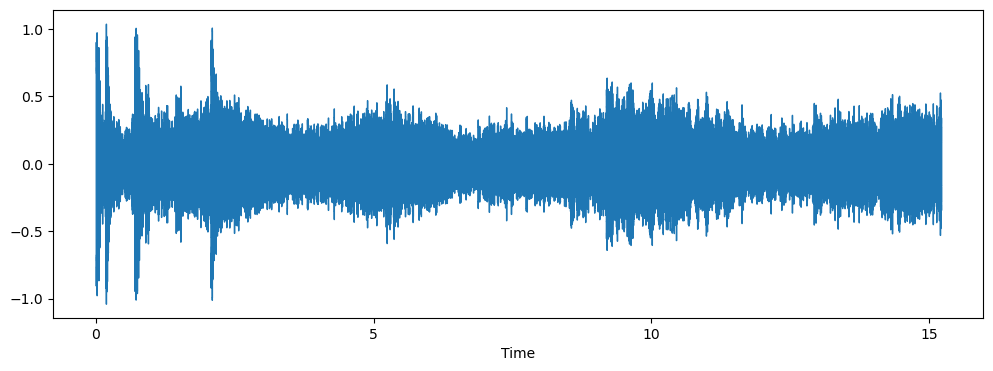

In [8]:
filename = '../Testing/3.wav'
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveshow(data,sr=sample_rate)
ipd.Audio(filename)

In [9]:
print_prediction(filename)

1/1 [==============================] - 0s 56ms/step
Emergency Vehicle


In [12]:
pip install pyaudio

     ------------------------------------ 164.0/164.0 kB 468.7 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [17]:
import pyaudio
#import struct
#import time
#import librosa.display

RATE = 22050
CHUNK = RATE*3
FORMAT = pyaudio.paInt16
CHANNELS = 1

# Identify which input is the mic - use to change input_device_index below
p = pyaudio.PyAudio()

stream = p.open(
    format=FORMAT,
    channels=CHANNELS,
    rate=RATE,
    input_device_index=16, # CHANGE
    input=True,
    output=True,
    frames_per_buffer=CHUNK
 )


import sounddevice as sd

num_rows = 40
num_columns = 130
num_channels = 1

#alldata = [] # Used to play back audio for testing 

prob_thresh = 0.98 # probability threshold for detecting the siren

while True:
#for i in range(0,5):
    data = stream.read(CHUNK, exception_on_overflow=False)
    data_int = np.frombuffer(data, dtype=np.int16)
    
    #alldata = np.append(alldata, data_int) 
    
    data_int = get_mfccs(data_int)

    prediction_feature = data_int.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict(prediction_feature)
    # predicted_proba_vector = model.predict_proba(prediction_feature)

    #print(predicted_vector)
    
    print("not_siren: ", predicted_vector[0][0], "siren: ", predicted_vector[0][1])
    
    if predicted_vector[0][1] > prob_thresh:
        print('SIREN!!!')
    else:
        print('No siren. Carry on.')

OSError: [Errno -9993] Illegal combination of I/O devices